# Synthetic Discussions analysis

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

from tasks.graphs import save_plot
from tasks.stats import ndfu

In [2]:
def get_annotations(annot_str: str) -> dict:
    """Extracts all key-value pairs from the annotation string into a dictionary."""
    try:
        annot_str = str(annot_str).lower()
        # Regex to match key-value pairs of the form type=value
        pattern = r"(\w+)=([-\d\.]+)"
        matches = re.findall(pattern, annot_str)
        return {key: float(value) if '.' in value else int(value) for key, value in matches}
    except Exception as e:
        return {}


def get_user_intent(prompt: str) -> str:
    prompt = prompt.lower()

    if "community" in prompt:
        return "Community-oriented"
    elif "troll" in prompt:
        return "Troll"
    elif "special_instructions: ," in prompt:
        return "Neutral"
    else:
        return "Unknown"


def generate_message_hash(conv_id: str, message: str, hash_func=hash) -> str:
    return hash_func(hash_func(conv_id) + hash_func(message))


def reset_count(df):
    order_by_conv = df.groupby("conv_id")

def add_message_order(df: pd.DataFrame) -> pd.DataFrame:
    i = 1
    last_conv_id = -1
    last_message_id = -1
    numbers = []

    for _, row in df.iterrows():
        new_conv_id = row["conv_id"]
        new_message_id = row["message_id"]

        if new_conv_id != last_conv_id:
            last_conv_id = new_conv_id
            last_message_id = new_message_id
            i = 1
        elif new_message_id != last_message_id:
            i += 1
            last_message_id = new_message_id

        numbers.append(i)
    return numbers
    

df = pd.read_csv("../data/dataset.csv", encoding="utf8")
df = df.astype(str)


# Extract all annotations from the 'annotation' column
annotations = df['annotation'].apply(get_annotations)

# Convert each annotation dictionary into separate columns
annotations_df = pd.json_normalize(annotations)

# Concatenate the new columns with the original dataframe
df = pd.concat([df, annotations_df], axis=1)

df = df[(df.toxicity != -1) | (df.argumentquality != -1)]
df = df[~df.message.apply(lambda x: len(x.strip()) < 3)]

# Process other columns as needed
df.is_moderator = (df.is_moderator == "True").astype(bool)
df["intent"] = df.user_prompt.apply(get_user_intent).astype(str)
df.intent = np.where(df.is_moderator, "Moderator", df.intent).astype(str)

df['message_id'] = df.apply(lambda row: generate_message_hash(row['conv_id'], row['message']), axis=1)
df["message_order"] = add_message_order(df)

df["polarization"] = df.groupby(["conv_id", "message"])['toxicity'].transform(lambda x: ndfu(x, histogram_input=False)).astype(float)

df = df.loc[:, ["conv_id", "message_id", "message_order", "conv_variant", "user", "user_prompt", "is_moderator", "intent", "message"] + list(annotations_df.columns) + ["polarization"]]
df

,conv_id,message_id,message_order,conv_variant,user,user_prompt,is_moderator,intent,message,toxicity,argumentquality,polarization
0,e470e71c-6473-407f-bd14-12c66828b5d5,-1610828411679813498,1,collective_constitution,StoicCarpenter56,You are a human participating in an online cha...,False,Community-oriented,All men are sex offenders? Really? A sexual pr...,4,2,0.1
1,e470e71c-6473-407f-bd14-12c66828b5d5,-1610828411679813498,1,collective_constitution,StoicCarpenter56,You are a human participating in an online cha...,False,Community-oriented,All men are sex offenders? Really? A sexual pr...,4,2,0.1
2,e470e71c-6473-407f-bd14-12c66828b5d5,-1610828411679813498,1,collective_constitution,StoicCarpenter56,You are a human participating in an online cha...,False,Community-oriented,All men are sex offenders? Really? A sexual pr...,4,2,0.1
3,e470e71c-6473-407f-bd14-12c66828b5d5,-1610828411679813498,1,collective_constitution,StoicCarpenter56,You are a human participating in an online cha...,False,Community-oriented,All men are sex offenders? Really? A sexual pr...,4,2,0.1
4,e470e71c-6473-407f-bd14-12c66828b5d5,-1610828411679813498,1,collective_constitution,StoicCarpenter56,You are a human participating in an online cha...,False,Community-oriented,All men are sex offenders? Really? A sexual pr...,4,2,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
15153,ce54c6c9-6b00-4cf4-96e3-48e4b90585f7,1766265889075593914,27,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,"@LostInThought52, thank you for your thoughtfu...",1,5,0.0
15154,ce54c6c9-6b00-4cf4-96e3-48e4b90585f7,1766265889075593914,27,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,"@LostInThought52, thank you for your thoughtfu...",1,5,0.0
15155,ce54c6c9-6b00-4cf4-96e3-48e4b90585f7,1766265889075593914,27,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,"@LostInThought52, thank you for your thoughtfu...",1,5,0.0
15156,ce54c6c9-6b00-4cf4-96e3-48e4b90585f7,1766265889075593914,27,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,"@LostInThought52, thank you for your thoughtfu...",1,5,0.0


In [3]:
df.intent.unique()

array(['Community-oriented', 'Troll', 'Moderator', 'Neutral'],
      dtype=object)

## Analysis

In [4]:
GRAPH_OUTPUT_DIR = Path("../graphs")
TOXICITY_TICKS = np.arange(1, 6, 1)

sns.set(style="whitegrid")

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


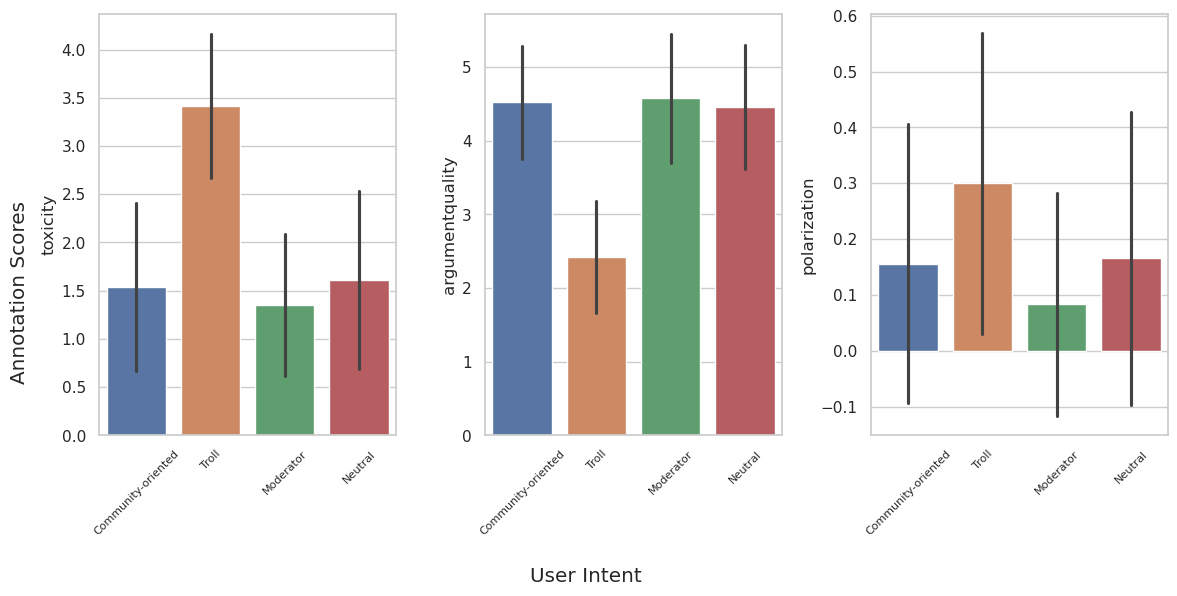

In [5]:
METRICS = ["toxicity", "argumentquality", "polarization"]

fig, axes = plt.subplots(1, len(METRICS))
fig.set_size_inches(12, 6)

for ax, metric in zip(axes, METRICS):
    # Create the bar plot
    sns.barplot(
        data=df,
        x="intent",
        hue="intent",
        y=metric,
        errorbar="sd",
        legend=False,
        ax=ax
    )
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.set_xlabel("")


fig.supxlabel("User Intent")
fig.supylabel("Annotation Scores")
fig.tight_layout()

save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/conv_variant_barplot.png


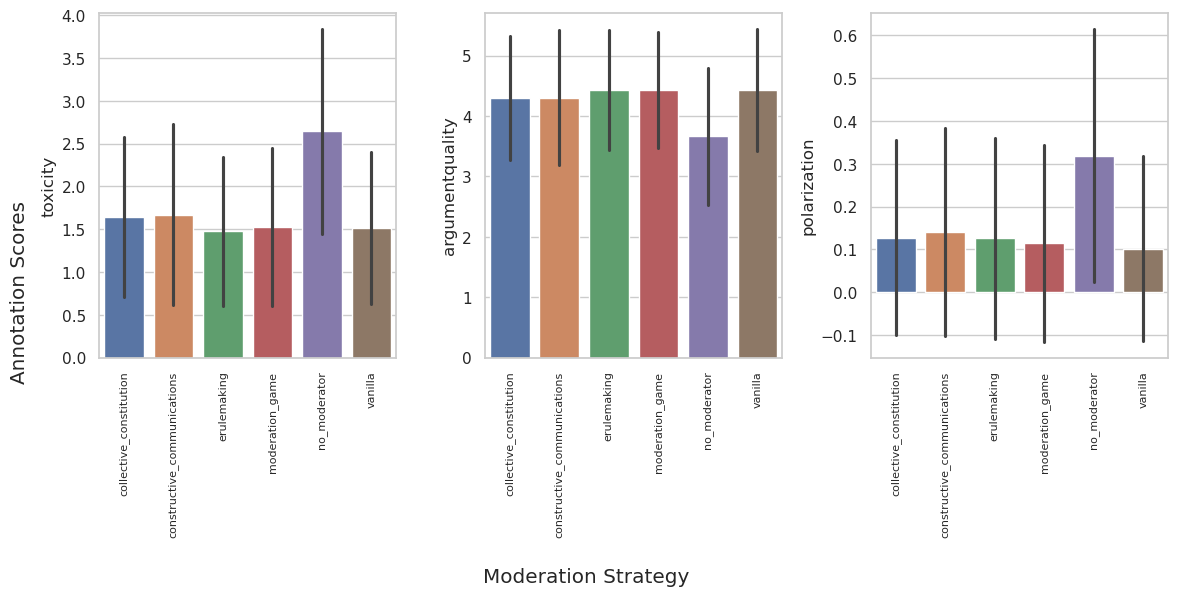

In [6]:
fig, axes = plt.subplots(1, len(METRICS))
fig.set_size_inches(12, 6)

for ax, metric in zip(axes, METRICS):
    sns.barplot(
        data=df,
        x="conv_variant",
        hue="conv_variant",
        y=metric,
        errorbar="sd",
        legend=False,
        ax=ax
    )
    ax.tick_params(axis='x', labelrotation=90, labelsize=8)
    ax.set_xlabel("")

fig.supxlabel("Moderation Strategy")
fig.supylabel("Annotation Scores")
fig.set_size_inches(12, 6)
fig.tight_layout()

save_plot(path=GRAPH_OUTPUT_DIR / "conv_variant_barplot.png")
plt.show()

### Progression of toxicity

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14223 entries, 0 to 15157
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   conv_id          14223 non-null  object 
 1   message_id       14223 non-null  int64  
 2   message_order    14223 non-null  int64  
 3   conv_variant     14223 non-null  object 
 4   user             14223 non-null  object 
 5   user_prompt      14223 non-null  object 
 6   is_moderator     14223 non-null  bool   
 7   intent           14223 non-null  object 
 8   message          14223 non-null  object 
 9   toxicity         14223 non-null  int64  
 10  argumentquality  14223 non-null  int64  
 11  polarization     14223 non-null  float64
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 1.3+ MB


In [19]:
def plot_timeseries_heatmap(timeseries_df: pd.DataFrame, metric_column: str) -> None:
    """
    Plots a heatmap showing the toxicity of all conversations over message order, sorted by discussion length.

    :param timeseries_df: DataFrame containing conversation data with toxicity and message_order
    :param metric: The metric to display in the heatmap title
    """
    # Count messages per conversation and sort conv_id accordingly
    #discussion_lengths = timeseries_df.groupby("conv_id").size().sort_values(ascending=False)
    #sorted_conversations = discussion_lengths.index.tolist()
    
    # Sort the dataframe based on the sorted conversation IDs
    #sorted_df = timeseries_df[timeseries_df["conv_id"].isin(sorted_conversations)]
    #sorted_df["conv_id"] = pd.Categorical(sorted_df["conv_id"], categories=sorted_conversations, ordered=True)

    # Pivot the data to create a heatmap structure
    #heatmap_data = sorted_df.pivot(index="conv_id", columns="message_order", values="toxicity")

    # Group by 'conv_id' and 'message_order', then calculate the average of the metric column
    heatmap_data = df.groupby(['conv_id', 'message_order'])[metric_column].mean().unstack()

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_data, cmap='cividis', cbar_kws={'label': f'Average {metric_column.capitalize()}'}, annot=False, fmt='.2f')
    ax.grid(False)
    ax.set(yticklabels=[])

    plt.title(f'Average {metric_column.capitalize()} per Conversation ID and Message Order')
    plt.xlabel('Message Order')
    plt.ylabel('Conversation ID')

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_heatmap.png


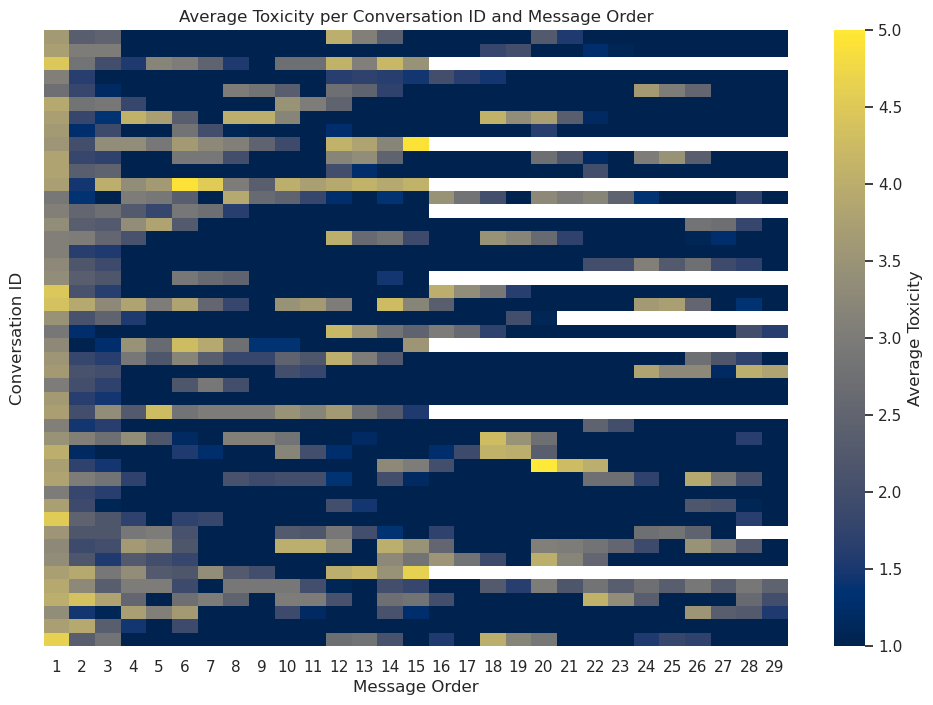

In [20]:
plot_timeseries_heatmap(df, "toxicity")
save_plot(path=GRAPH_OUTPUT_DIR / "toxicity_heatmap.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/polarization_heatmap.png


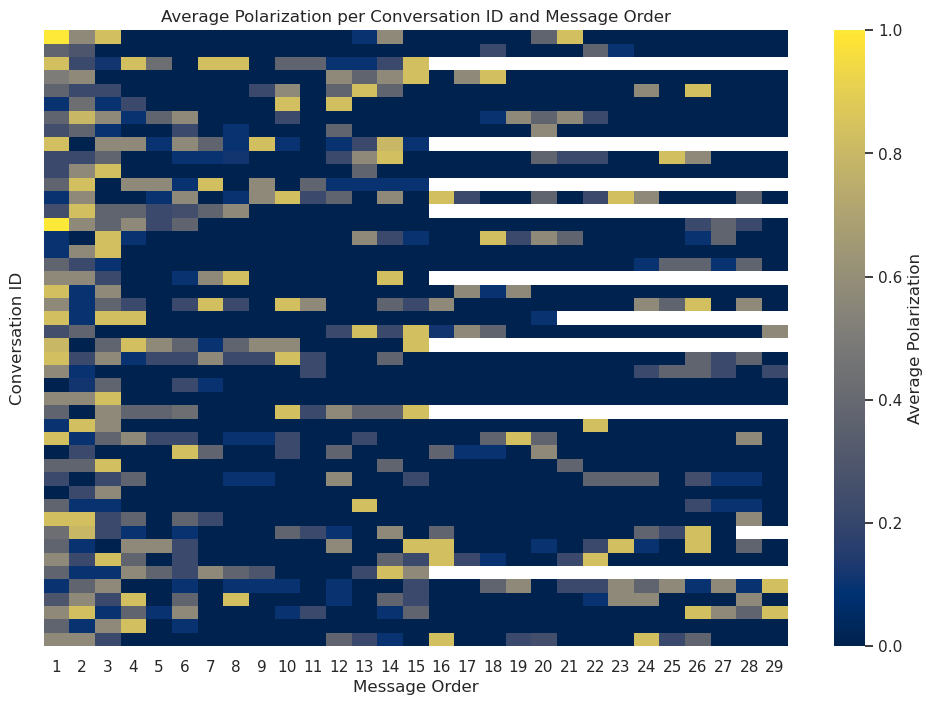

In [21]:
plot_timeseries_heatmap(df, "polarization")
save_plot(path=GRAPH_OUTPUT_DIR / "polarization_heatmap.png")
plt.show()

### Moderator impact

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_toxicity_timeseries.png


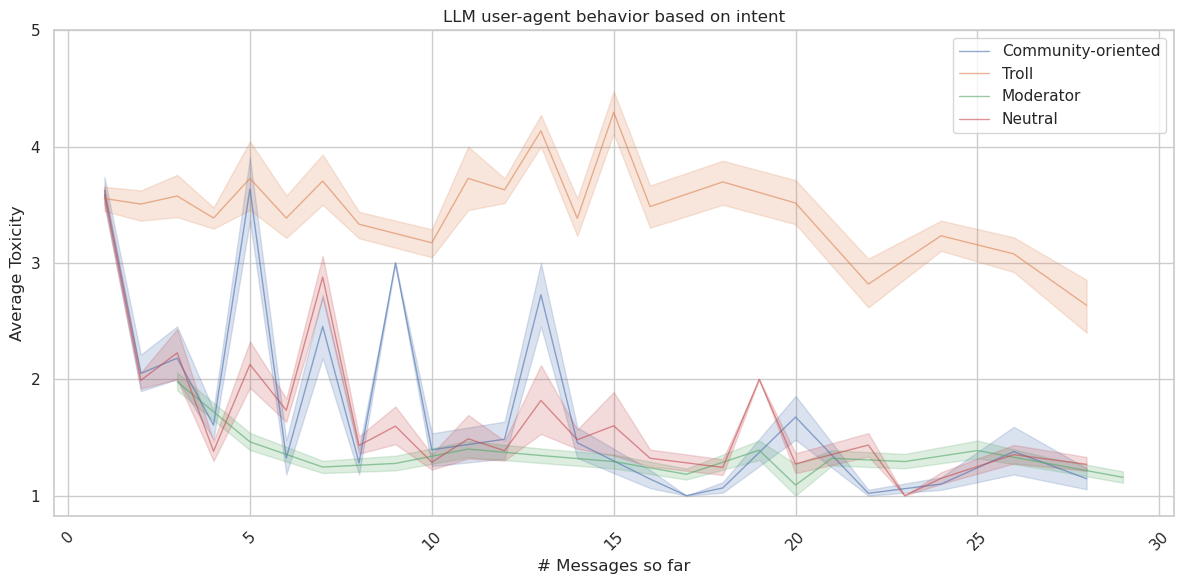

In [22]:
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df,
    x="message_order",
    y="toxicity",
    hue="intent",
    lw=1,
    alpha=0.6,
)

plt.title("LLM user-agent behavior based on intent")
plt.xlabel("# Messages so far")
plt.ylabel("Average Toxicity")
plt.xticks(rotation=45)
plt.yticks(TOXICITY_TICKS)
plt.legend()
plt.tight_layout()

save_plot(path=GRAPH_OUTPUT_DIR / "intent_toxicity_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_toxicity_timeseries.png


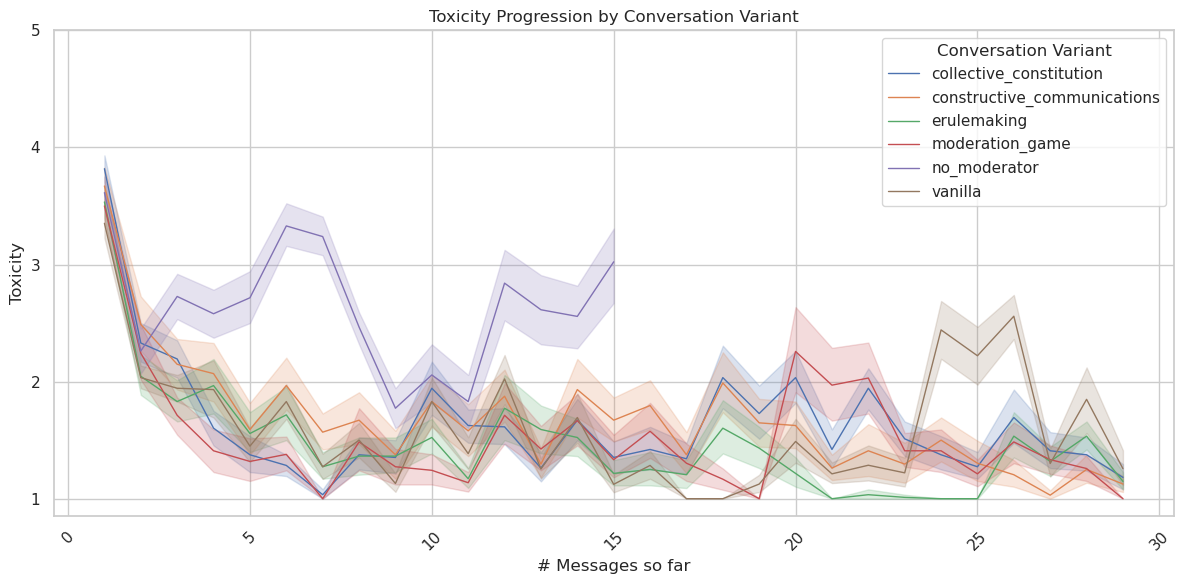

In [23]:
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df,
    x="message_order", 
    y="toxicity", 
    hue="conv_variant",  # Different lines for each variant
    lw=1, 
    alpha=1,
    #errorbar=None
)

plt.title("Toxicity Progression by Conversation Variant")
plt.xlabel("# Messages so far")
plt.ylabel("Toxicity")
plt.xticks(rotation=45)
plt.yticks(TOXICITY_TICKS)
plt.legend(title="Conversation Variant")
plt.tight_layout()

save_plot(path=GRAPH_OUTPUT_DIR / "strategy_toxicity_timeseries.png")
plt.show()

## Moderator Interventions

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


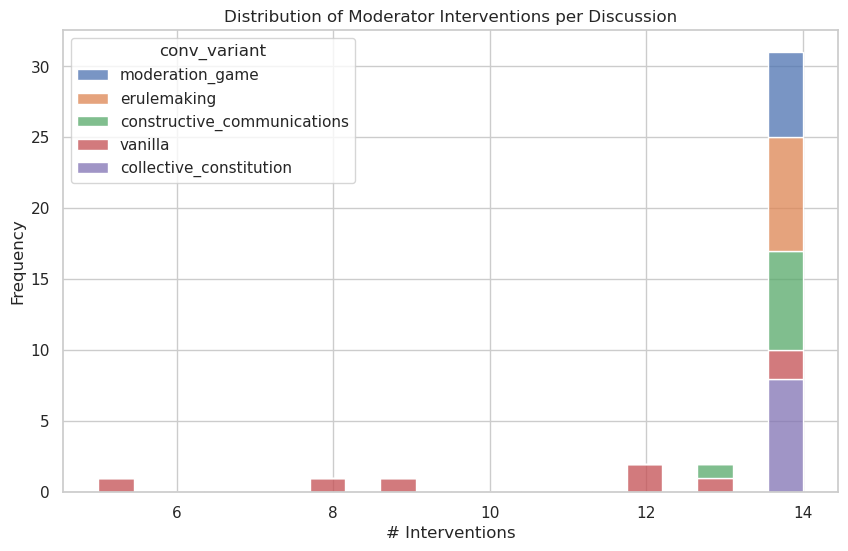

In [24]:
df_unique = df[df["conv_variant"] != "no_moderator"].drop_duplicates(subset=["conv_id", "message"])

# Compute number of moderator interventions per conversation
moderator_interventions = df_unique[df_unique["is_moderator"]].groupby("conv_id").size()

# Merge with conversation variants
conv_variants = df_unique[["conv_id", "conv_variant"]].drop_duplicates().set_index("conv_id")
moderator_interventions = moderator_interventions.to_frame(name="moderator_interventions").join(conv_variants, how="left")

plt.figure(figsize=(10, 6))
sns.histplot(data=moderator_interventions, x="moderator_interventions", hue="conv_variant", multiple="stack", bins=20)
plt.xlabel("# Interventions")
plt.ylabel("Frequency")
plt.title("Distribution of Moderator Interventions per Discussion")

save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()